In [ ]:
# default_exp inferno_interp

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Interpolation INFERNO loss

Attempted reproduction INFERNO following paper description implementations with nuisances being approximated by creating up/down shapes and interpolating
Runs and reproduces some of the paper results

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from pytorch_inferno.callback import AbsCallback, PredHandler
from pytorch_inferno.inference import calc_nll, calc_grad_hesse

import numpy as np
from abc import abstractmethod
from typing import Tuple, Optional, List
from fastcore.all import store_attr, partialler

import torch.nn as nn
from torch import Tensor
import torch
from torch.distributions import Distribution

In [ ]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict

import torch.nn.functional as F
from torch import optim, autograd
import torch
from torch.distributions import Normal

# Network

In [ ]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [ ]:
# export
class VariableSoftmax(nn.Softmax):
    r'''Softmax with temperature'''
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)

In [ ]:
x = torch.randn((1,10))

In [ ]:
VariableSoftmax(0.1)(x), VariableSoftmax(0.5)(x), VariableSoftmax(1)(x)

(tensor([[1.5689e-13, 1.6554e-11, 2.1804e-06, 1.0616e-11, 3.6025e-15, 9.9580e-01,
          4.1964e-03, 7.9640e-08, 2.0078e-06, 3.1487e-06]]),
 tensor([[0.0017, 0.0043, 0.0457, 0.0040, 0.0008, 0.6187, 0.2072, 0.0236, 0.0449,
          0.0491]]),
 tensor([[0.0184, 0.0293, 0.0954, 0.0281, 0.0126, 0.3510, 0.2032, 0.0685, 0.0946,
          0.0989]]))

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)

# Loss

In [ ]:
x,y,w = next(iter(data.trn_dl))
preds = net(x)
assert preds.shape == (bs,10)

In [ ]:
def to_shape(p:Tensor) -> Tensor:
    f = p.sum(0)
    f = f/f.sum()
    return f

In [ ]:
m = y.squeeze()==0
f_s = to_shape(preds[~m])
f_b = to_shape(preds[m])

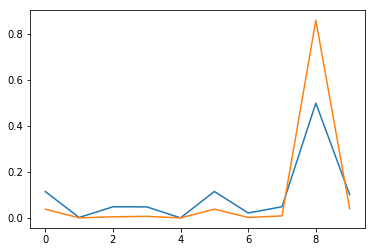

In [ ]:
plt.plot(to_np(f_s))
plt.plot(to_np(f_b))

Class initialised with a true number of signal events $\mu$ and a true number of events $n$. The true number of background events is then computed as $n-mu$. The number of nuisance parameters must also be passed.

This process only approximates the effect of shape systematics, since they are evaluated as up/down shape variations and the inter-dependence of them is not accounted for. It is, however, perhaps more realistic/practical, since the exact effect of the nuisances on the input features do not have to be analytically derivable, instead one can use up/down Monte Carlo samples. For this synthetic example, the analytical effects are used.

Running cycle is:
1. for e in #epochs:
    1. for b in #batches:
        1. on_forwards_end:
            1. compute up/down shape variations by augmenting data and passing through model
            1. set alpha as tensor with gradient and `n_alpha+1` elements. Set element zero to $\mu$
            1. compute the full hessian of the negative log-likelihood w.r.t alpha (shape systematics included by running model augmented data to get up/down shapes)
            1. invert hessian and set the diagonal element corresponding to $\mu$ as the loss value

In [ ]:
# export
class AbsInferno(AbsCallback):
    r'''Attempted reproduction INFERNO following paper description implementations with nuisances being approximated by creating up/down shapes and interpolating
    Includes option to randomise params per batch and converge to better values, which results in slightly better performance'''
    def __init__(self, n:int, true_mu:float, aug_alpha:bool=False, n_alphas:int=0, n_steps:int=100, lr:float=0.1,
                 float_b:bool=False, alpha_aux:Optional[List[Distribution]]=None, b_aux:Optional[Distribution]=None):
        super().__init__()
        store_attr()
        self.true_b = self.n-self.true_mu
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
    
    @staticmethod
    def to_shape(p:Tensor) -> Tensor:
        f = p.sum(0)+1e-7
        return f/f.sum()
        
    @abstractmethod
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        r'''Compute upd/down shapes. Overide this for specific problem.'''
        pass
    
    def get_ikk(self, f_s:Tensor, f_b_nom:Tensor, f_b_up:Tensor, f_b_dw:Tensor) -> Tensor:
        r'''Compute full hessian at true param values, or at random starting values with Newton updates'''
        if self.aug_alpha: alpha = torch.randn((self.n_alphas+1+self.float_b), requires_grad=True, device=self.wrapper.device)/10
        else:              alpha = torch.zeros((self.n_alphas+1+self.float_b), requires_grad=True, device=self.wrapper.device)
        with torch.no_grad(): alpha[0] += self.true_mu
        get_nll = partialler(calc_nll, s_true=self.true_mu, b_true=self.true_b,
                             f_s=f_s, f_b_nom=f_b_nom, f_b_up=f_b_up, f_b_dw=f_b_dw, alpha_aux=self.alpha_aux, b_aux=self.b_aux)
        if self.aug_alpha:  # Alphas carry noise, optimise via Newton
            for i in range(self.n_steps):  # Newton optimise nuisances & mu
                nll = get_nll(s_exp=alpha[0], b_exp=self.true_b+alpha[1] if self.float_b else self.true_b, alpha=alpha[1+self.float_b:])
                g,h = calc_grad_hesse(nll, alpha)
                s = torch.clamp(self.lr*g.detach()@torch.inverse(h), -100, 100)
                alpha = alpha-s
        nll = get_nll(s_exp=alpha[0], b_exp=self.true_b+alpha[1] if self.float_b else self.true_b, alpha=alpha[1+self.float_b:])
        _,h = calc_grad_hesse(nll, alpha, create_graph=True)
#         print('hess', h)
#         print('inverse', torch.inverse(h))
#         print('reciprocal', 1/h)
        return torch.inverse(h)[0,0]
        
    def on_forwards_end(self) -> None:
        r'''Compute loss and replace wrapper loss value'''
        b = self.wrapper.y.squeeze() == 0
        f_s = self.to_shape(self.wrapper.y_pred[~b])
        f_b = self.to_shape(self.wrapper.y_pred[b])
        f_b_up,f_b_dw = self._get_up_down(self.wrapper.x[b])
        self.wrapper.loss_val = self.get_ikk(f_s=f_s, f_b_nom=f_b, f_b_up=f_b_up, f_b_dw=f_b_dw)

In [ ]:
# export
class PaperInferno(AbsInferno):
    r'''Inheriting class for dealing with INFERNO paper synthetic problem'''
    def __init__(self, r_mods:Optional[Tuple[float,float]]=(-0.2,0.2), l_mods:Optional[Tuple[float,float]]=(2.5,3.5), l_init:float=3,
                 n:int=1050, true_mu:int=50, aug_alpha:bool=False, n_steps:int=10, lr:float=0.1,
                 float_b:bool=False, alpha_aux:Optional[List[Distribution]]=None, b_aux:Optional[Distribution]=None):
        super().__init__(n=n, true_mu=true_mu, aug_alpha=aug_alpha, n_alphas=(r_mods is not None)+(l_mods is not None), n_steps=n_steps, lr=lr,
                         float_b=float_b, alpha_aux=alpha_aux, b_aux=b_aux)
        self.r_mods,self.l_mods,self.l_init = r_mods,l_mods,l_init
        
    def on_train_begin(self) -> None:
        if self.r_mods is not None:
            self.r_mod_t = (torch.zeros(1,3, device=self.wrapper.device),torch.zeros(1,3, device=self.wrapper.device))
            self.r_mod_t[0][0,0] = self.r_mods[0]
            self.r_mod_t[1][0,0] = self.r_mods[1]
        if self.l_mods is not None:
            self.l_mod_t = (torch.ones(1,3, device=self.wrapper.device),torch.ones(1,3, device=self.wrapper.device))
            self.l_mod_t[0][0,2] = self.l_mods[0]/self.l_init
            self.l_mod_t[1][0,2] = self.l_mods[1]/self.l_init
    
    def _get_up_down(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        if self.r_mods is None and self.l_mods is None: return None,None
        u,d = [],[]
        if self.r_mods is not None:
            x = x+self.r_mod_t[0]
            d.append(self.to_shape(self.wrapper.model(x)))
            x = x+self.r_mod_t[1]-self.r_mod_t[0]
            u.append(self.to_shape(self.wrapper.model(x)))
            x = x-self.r_mod_t[1]
        if self.l_mods is not None:
            x = x*self.l_mod_t[0]
            d.append(self.to_shape(self.wrapper.model(x)))
            x = x*self.l_mod_t[1]/self.l_mod_t[0]
            u.append(self.to_shape(self.wrapper.model(x)))
            x = x/self.l_mod_t[1]
        return torch.stack(u),torch.stack(d)

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [ ]:
%%time
model.fit(5, data=data, opt=partialler(optim.Adam,lr=1e-3), loss=None,
          cbs=[PaperInferno(alpha_aux=[Normal(0,2), Normal(0,2)], float_b=True, b_aux=Normal(1000,100), aug_alpha=False, n_steps=10),
               LossTracker(),SaveBest('weights/best_ii.h5'),EarlyStopping(2)])

1: Train=1034.4642358398437 Valid=603.6358245849609
2: Train=505.40827026367185 Valid=466.38184326171876
3: Train=443.86060546875 Valid=419.23767944335935
4: Train=421.30035522460935 Valid=414.1907116699219
5: Train=407.6061544799805 Valid=394.6520983886719
Loading best model with loss 394.6520983886719
CPU times: user 49.6 s, sys: 7.13 s, total: 56.7 s
Wall time: 50.5 s


In [ ]:
model.save('weights/Inferno_Test_interp_bm2.h5')

In [ ]:
model.load('weights/Inferno_Test_interp_bm2.h5')

# Results

In [ ]:
# export
class InfernoPred(PredHandler):
    r'''Prediction handler for hard assignments'''
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)

## BM 0

In [ ]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [ ]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,5,1.0
1,6,1.0
2,6,1.0
3,7,1.0
4,0,1.0


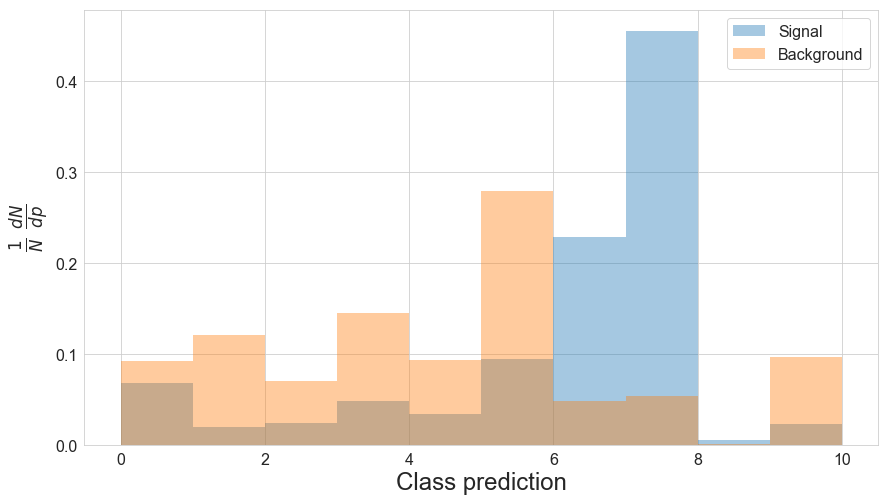

In [ ]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [ ]:
bin_preds(df)

In [ ]:
df.head()

,pred,gen_target,pred_bin
0,5,1.0,5
1,6,1.0,6
2,6,1.0,6
3,7,1.0,7
4,0,1.0,0


In [ ]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [ ]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.0000))

In [ ]:
f_s, f_b

(tensor([0.0677, 0.0192, 0.0243, 0.0485, 0.0333, 0.0944, 0.2284, 0.4554, 0.0057,
         0.0231]),
 tensor([0.0925, 0.1210, 0.0701, 0.1450, 0.0934, 0.2785, 0.0486, 0.0531, 0.0010,
         0.0967]))

In [ ]:
asimov = (50*f_s)+(1000*f_b)

In [ ]:
asimov, asimov.sum()

(tensor([ 95.9059, 121.9863,  71.3298, 147.4345,  95.0968, 283.2639,  59.9894,
          75.8907,   1.2530,  97.8497]), tensor(1050.))

In [ ]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([32.18667984, 32.05523682, 31.92905235, 31.80807114, 31.69220352,
       31.58148193, 31.47578239, 31.37491989, 31.27903366, 31.18791199,
       31.10140991, 31.01999283, 30.94278526, 30.87038422, 30.80237961,
       30.73923874, 30.680233  , 30.6255455 , 30.5754776 , 30.52940559,
       30.48774338, 30.45025635, 30.41691971, 30.38750076, 30.3621521 ,
       30.34085846, 30.32363701, 30.31031609, 30.30096054, 30.29518318,
       30.29336929, 30.29492378, 30.30071449, 30.30990219, 30.3227005 ,
       30.33930969, 30.35948181, 30.38277435, 30.41010475, 30.44046593,
       30.47445107, 30.51177216, 30.5525322 , 30.59642792, 30.64375114,
       30.69425583, 30.74801636, 30.80485153, 30.86514091, 30.92841339,
       30.99471283, 31.0640564 , 31.13644028, 31.21195984, 31.29033852,
       31.37195587, 31.45611382, 31.54337311, 31.63347626, 31.72654343,
       31.82230377])

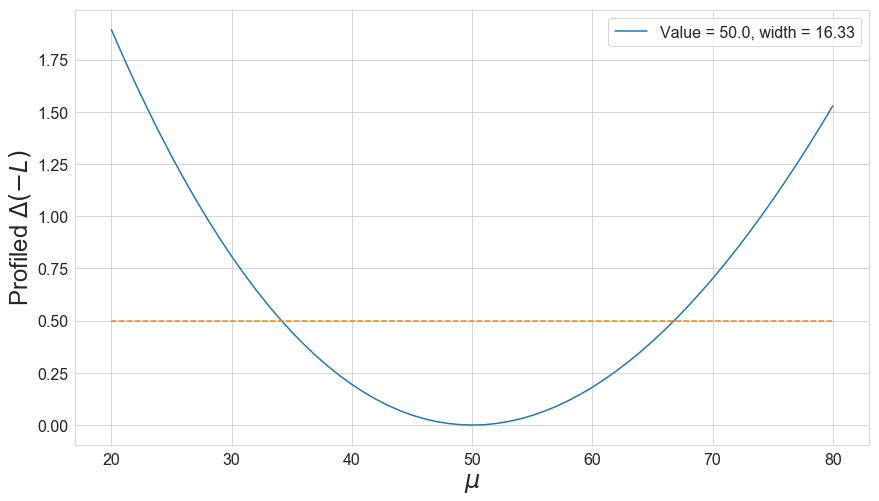

In [ ]:
plot_likelihood(y-y.min())

# Nuisances - via interpolation

In [ ]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [ ]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [ ]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,5,1.0,5,5,5,5,5,5,5,5,5,5,5
1,6,1.0,6,6,6,6,6,6,6,6,6,6,6
2,6,1.0,6,6,6,6,6,6,6,6,6,6,6
3,7,1.0,7,7,7,7,7,7,7,7,7,7,7
4,0,1.0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1,0.0,1,9,9,1,1,1,1,1,1,9,9
999996,0,0.0,0,0,0,0,0,0,0,0,0,0,0
999997,7,0.0,7,7,7,7,7,7,7,7,7,7,7
999998,2,0.0,2,2,2,2,2,2,2,2,2,2,2


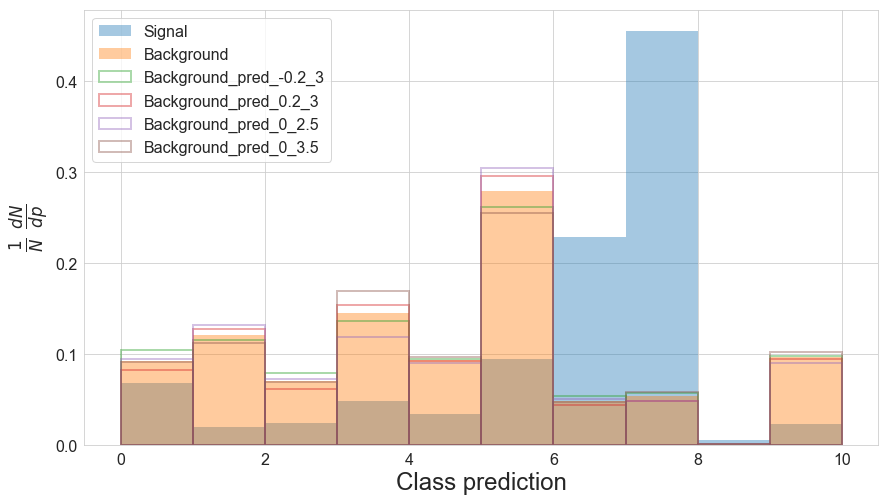

In [ ]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([0.1056, 0.1257, 0.0812, 0.1093, 0.0909, 0.2876, 0.0553, 0.0523, 0.0006,
        0.0914])
tensor([0.1037, 0.1150, 0.0795, 0.1363, 0.0943, 0.2613, 0.0536, 0.0573, 0.0010,
        0.0980])
tensor([0.1021, 0.1054, 0.0779, 0.1601, 0.0973, 0.2380, 0.0519, 0.0624, 0.0013,
        0.1037])
tensor([0.0945, 0.1318, 0.0718, 0.1180, 0.0900, 0.3048, 0.0503, 0.0480, 0.0006,
        0.0901])
tensor([0.0925, 0.1210, 0.0701, 0.1450, 0.0934, 0.2785, 0.0486, 0.0531, 0.0010,
        0.0967])
tensor([0.0909, 0.1115, 0.0685, 0.1688, 0.0964, 0.2553, 0.0469, 0.0581, 0.0013,
        0.1024])
tensor([0.0844, 0.1375, 0.0631, 0.1264, 0.0883, 0.3223, 0.0458, 0.0434, 0.0004,
        0.0883])
tensor([0.0824, 0.1268, 0.0614, 0.1535, 0.0917, 0.2960, 0.0440, 0.0485, 0.0009,
        0.0949])
tensor([0.0808, 0.1172, 0.0598, 0.1772, 0.0947, 0.2727, 0.0423, 0.0535, 0.0012,
        0.1005])


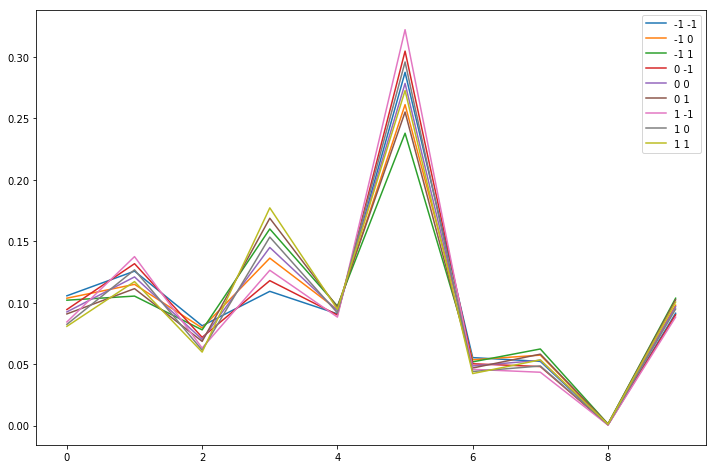

In [ ]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [ ]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [ ]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [ ]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [ ]:
nll = to_np(nll)

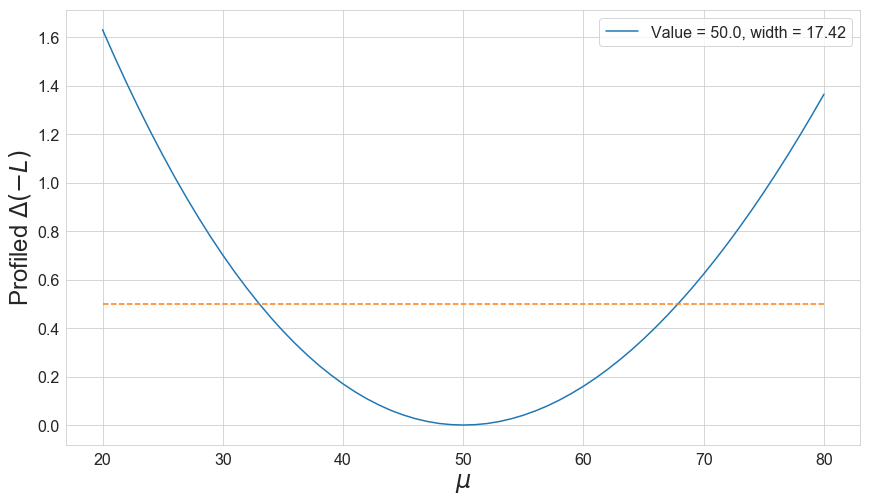

In [ ]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [ ]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

In [ ]:
nll = to_np(nll)

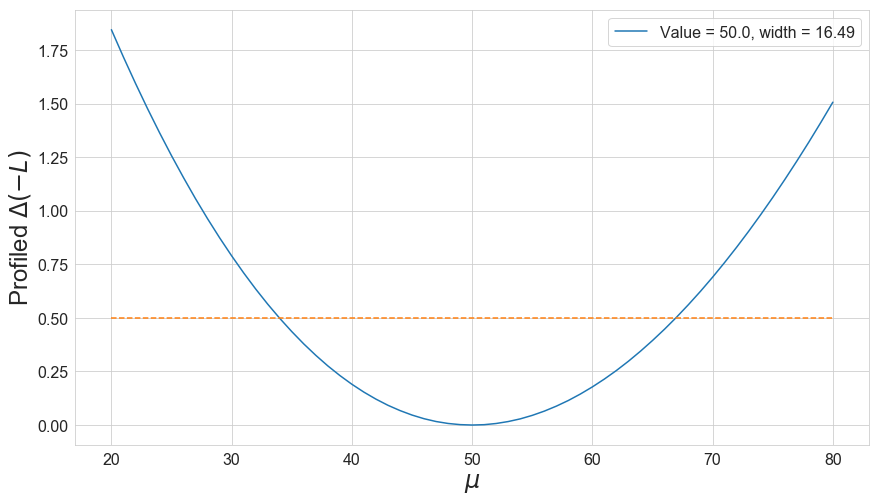

In [ ]:
plot_likelihood(nll-nll.min())

## BM 2

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

In [ ]:
nll = to_np(nll)

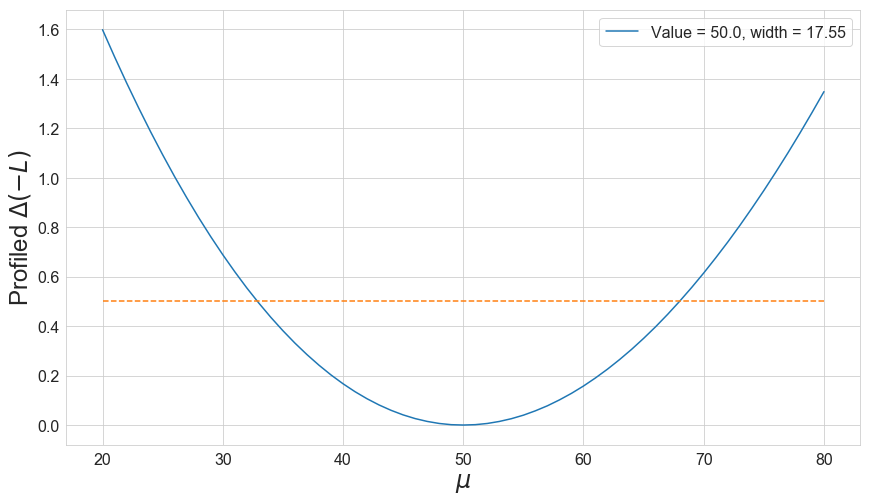

In [ ]:
plot_likelihood(nll-nll.min())

## BM 3

In [ ]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, **b_shapes)

In [ ]:
nll = to_np(nll)

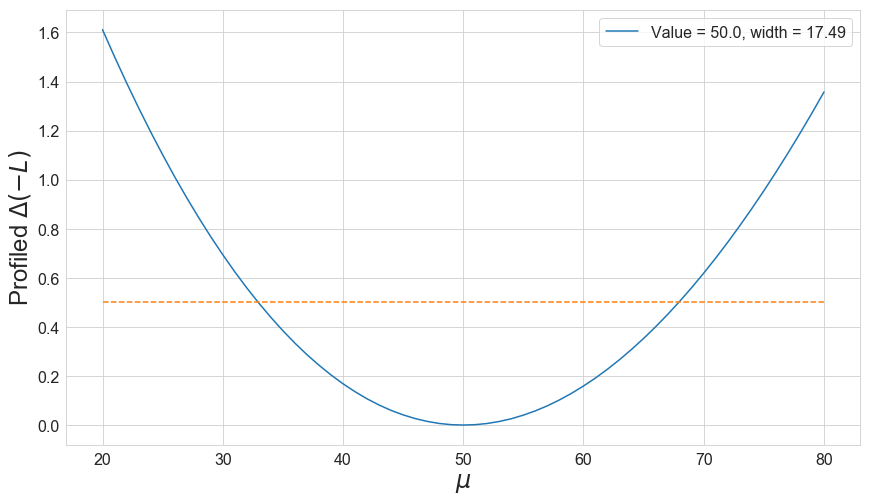

In [ ]:
plot_likelihood(nll-nll.min())

## BM 4

In [ ]:
alpha_aux = [Normal(0,2), Normal(0,2)]

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, alpha_aux=alpha_aux, float_b=True, b_aux=Normal(1000,100), **b_shapes)

Linear regime: Mu 20.0, alpha tensor([-0.2985,  0.0851, 25.6329])
Linear regime: Mu 21.0, alpha tensor([-0.2879,  0.0818, 24.7101])
Linear regime: Mu 22.0, alpha tensor([-0.2774,  0.0786, 23.7924])
Linear regime: Mu 23.0, alpha tensor([-0.2669,  0.0754, 22.8799])
Linear regime: Mu 24.0, alpha tensor([-0.2564,  0.0723, 21.9725])
Linear regime: Mu 25.0, alpha tensor([-0.2461,  0.0692, 21.0700])
Linear regime: Mu 26.0, alpha tensor([-0.2357,  0.0661, 20.1726])
Linear regime: Mu 27.0, alpha tensor([-0.2254,  0.0630, 19.2801])
Linear regime: Mu 28.0, alpha tensor([-0.2151,  0.0600, 18.3924])
Linear regime: Mu 29.0, alpha tensor([-0.2049,  0.0570, 17.5096])
Linear regime: Mu 30.0, alpha tensor([-0.1948,  0.0540, 16.6316])
Linear regime: Mu 31.0, alpha tensor([-0.1846,  0.0511, 15.7582])
Linear regime: Mu 32.0, alpha tensor([-0.1745,  0.0481, 14.8896])
Linear regime: Mu 33.0, alpha tensor([-0.1645,  0.0453, 14.0256])
Linear regime: Mu 34.0, alpha tensor([-0.1545,  0.0424, 13.1661])
Linear reg

In [ ]:
nll = to_np(nll)

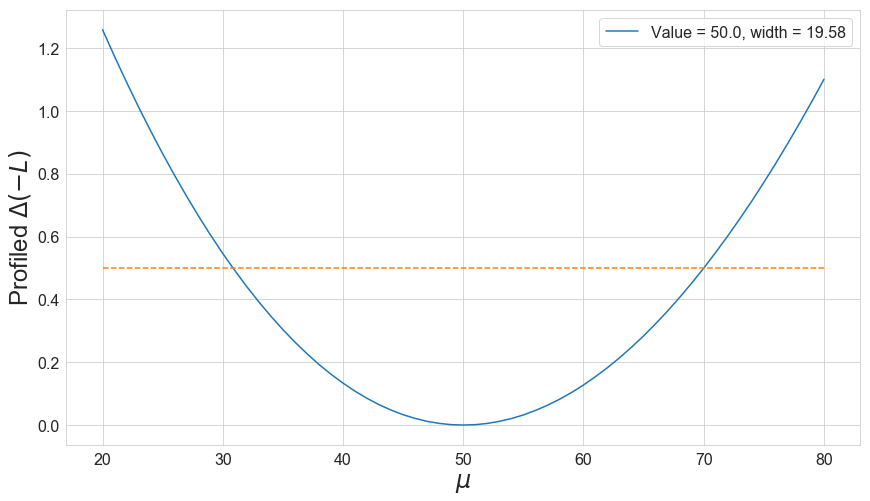

In [ ]:
plot_likelihood(nll-nll.min())